<div class="alert alert-block alert-info">
<p style="font-size:24px;text-align:center"><b>Initiate a laser pulse from the phase-intensity image pairs of a wavefront censor (WFS) diagnostic.</b></p>
<p style="font-size:24px;text-align:center">We begin with the <b>Pump Off</b> experimental configuration and then drift the pulse back by approximately 50 cm.</p>

***

<p style="font-size:18px;">This notebook considers an experimental configuration where the 800 nm seed laser pulse has propagated through a Ti:Sapphire crystal with the pump laser turned off. The diagnostic data is accumulated over the full longitudinal extent of a single laser pulse.</p>
<p style="font-size:18px;">The images used in this notebook are stored in the <b>rslaser</b> module, which must be imported.</p>
<p style="font-size:18px;">The following two files are specified, parsed and analyzed in this notebook.</p>

> ccd_name = 'ccd_pump_off.txt' 
<br> This file contains the photon count, perhaps normalized, which we loosely refer to as intensity.

> wfs_name = 'wfs_pump_off.txt' 
<br> This file contains the phase of the electric field. 
</div>

In [1]:
import array
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import os

from pykern.pkcollections import PKDict
# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    print("The rslaser library was not found; installing from GitHub...")
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser
from rslaser.optics import wavefront
from rslaser.optics import element
from rslaser.pulse import pulse

import scipy
from scipy import constants, ndimage, stats
from scipy.ndimage.filters import gaussian_filter

# SRW and srwlib (the corresponding Python API) are pre-installed on Sirepo/Jupyter
import srwlib
from srwlib import srwl

In [2]:
# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

# Specify whether 2D and/or 3D plots should be rendered
RENDER_2D_PLOTS = True
RENDER_3D_PLOTS = False

# 3D plotting
if RENDER_3D_PLOTS:
    import plotly.graph_objects as go

In [3]:
# Let's read an image-pair of diagnostic data files to instantiate an SRW wavefront.
# First, we have to determine the file paths...
ccd_name = 'ccd_pump_off.txt'
wfs_name = 'wfs_pump_off.txt'

package_data_dir = rslaser.pkg_resources.resource_filename('rslaser','package_data')
ccd_path_to_file = os.path.join(package_data_dir, ccd_name)
wfs_path_to_file = os.path.join(package_data_dir, wfs_name)

# read the pixel size from the diagnostic metadata file
meta_file_name = 'wfs_meta.dat'
meta_path_to_file = os.path.join(package_data_dir, meta_file_name)
with open(meta_path_to_file) as fh:
    for line in fh:
        if line.startswith("pixel_size_h_microns"):
            pixel_size_h = float(line.split(":")[-1].split(",")[0])  # microns
        if line.startswith("pixel_size_v_microns"):
            pixel_size_v = float(line.split(":")[-1].split(",")[0])  # microns

# central wavelength of the laser pulse
lambda0_micron = 0.8

In [4]:
def nan_helper(_arr):
    """
    Clean unwanted NaNs from a numpy array, replacing them via interpolation.

    Args:
        _arr, numpy array with NaNs
    
    Returns:
        nans, logical indices of NaNs
        index, a function with signature indices = index(logical_indices)
               to convert logical indices of NaNs to 'equivalent' indices

    Example:
        >>> nans, x = nan_helper(my_array)
        >>> my_array[nans] = np.interp(x(nans), x(~nans), my_array[~nans])
    """
    return np.isnan(_arr), lambda z: z.nonzero()[0]

def array_cleaner(_arr, _ind):
    """
    Clean unwanted values from a numpy array, replacing them via interpolation.

    Args:
        _arr, numpy array with bad values
        _ind, precalculated indices of these bad values
    
    Returns:
        _arr, cleaned version of the input array

    Example:
        >>> indices = np.isnan(my_array)
        >>> my_array = array_cleaner(my_array, indices)
    """
    _arr[_ind] = np.nan
    nans, x = nan_helper(_arr)
    _arr[nans] = np.interp(x(nans), x(~nans), _arr[~nans])
    return _arr

In [5]:
# parse the wave front sensor (WFS) diagnostic data file
wfs_data = np.genfromtxt(wfs_path_to_file, skip_header=1, skip_footer=0)

# clean up any NaN's
# nans, x = nan_helper(wfs_data)
# wfs_data[nans] = np.interp(x(nans), x(~nans), wfs_data[~nans])

# clean up any NaN's
indices = np.isnan(wfs_data)
wfs_data = array_cleaner(wfs_data, indices)

# pad with zeros
wfs_temp = np.pad(wfs_data, 4, mode='constant')

# smooth the data
blur = 4
wfs_data = gaussian_filter(wfs_temp, sigma=blur)

# convert from microns to radians
rad_per_micron = math.pi / lambda0_micron
wfs_data *= rad_per_micron

phi_min=np.min(wfs_data)
phi_max=np.max(wfs_data)

# parse the intensity diagnostic data file
ccd_data = np.genfromtxt(ccd_path_to_file, skip_header=1)

# pad with zeros
ccd_temp = np.pad(ccd_data, 4, mode='constant')

# smooth the data
blur = 2
ccd_data = gaussian_filter(ccd_temp, sigma=blur)

# we assume the WFS and CCD data are from the same diagnostic
# check that the data files have the same number of pixels
assert np.shape(wfs_data) == np.shape(ccd_data), error_message('ERROR -- WFS and CCD data have diferent shapes!!')

n0_min=np.min(ccd_data)
n0_max=np.max(ccd_data)

In [6]:
# create the x,y arrays with physical units based on the diagnostic pixel dimensions
x1_max = 0.5 * (wfs_data.shape[1] + 1.) * pixel_size_h * 1.e-3    # [mm]
x1_min = -x1_max
x1_delta = 2.*x1_max / wfs_data.shape[1]
x1 = np.arange(x1_min, x1_max, x1_delta)

y1_max = 0.5 * (wfs_data.shape[0] + 1.) * pixel_size_v * 1.e-3    # [mm]
y1_min = -y1_max
y1_delta = 2.*y1_max / wfs_data.shape[0]
y1 = np.arange(y1_min, y1_max, y1_delta)

x, y = np.meshgrid(x1, y1)

if True:
    print(' ')
    print('np.shape(x) = ', np.shape(x))
    print(' ')
    print('x = ', x)
    print(' ')
    print('y = ', y)

phi_min=np.min(wfs_data)
phi_max=np.max(wfs_data)
if False:
    print(' ')
    print('phi_min = ', phi_min)
    print('phi_max = ', phi_max)

 
np.shape(x) =  (40, 48)
 
x =  [[-2.8175     -2.70010417 -2.58270833 ...  2.4653125   2.58270833
   2.70010417]
 [-2.8175     -2.70010417 -2.58270833 ...  2.4653125   2.58270833
   2.70010417]
 [-2.8175     -2.70010417 -2.58270833 ...  2.4653125   2.58270833
   2.70010417]
 ...
 [-2.8175     -2.70010417 -2.58270833 ...  2.4653125   2.58270833
   2.70010417]
 [-2.8175     -2.70010417 -2.58270833 ...  2.4653125   2.58270833
   2.70010417]
 [-2.8175     -2.70010417 -2.58270833 ...  2.4653125   2.58270833
   2.70010417]]
 
y =  [[-2.30625   -2.30625   -2.30625   ... -2.30625   -2.30625   -2.30625  ]
 [-2.1909375 -2.1909375 -2.1909375 ... -2.1909375 -2.1909375 -2.1909375]
 [-2.075625  -2.075625  -2.075625  ... -2.075625  -2.075625  -2.075625 ]
 ...
 [ 1.9603125  1.9603125  1.9603125 ...  1.9603125  1.9603125  1.9603125]
 [ 2.075625   2.075625   2.075625  ...  2.075625   2.075625   2.075625 ]
 [ 2.1909375  2.1909375  2.1909375 ...  2.1909375  2.1909375  2.1909375]]


In [7]:
e_norm = np.sqrt(ccd_data)
ex_real = np.multiply(e_norm, np.cos(wfs_data)).flatten(order='C')
ex_imag = np.multiply(e_norm, np.sin(wfs_data)).flatten(order='C')

ex_numpy = np.zeros(2*len(ex_real))
for i in range(len(ex_real)):
    ex_numpy[2*i] = ex_real[i]
    ex_numpy[2*i+1] = ex_imag[i]

ex = array.array('f', ex_numpy.tolist())
ey = array.array('f', len(ex)*[0.])

In [8]:
wfr0 = srwlib.SRWLWfr(_arEx=ex, _arEy=ey, _typeE='f', 
                    _eStart=1.55, _eFin=1.55, _ne=1, 
                    _xStart=x1_min, _xFin=x1_max, _nx=np.shape(wfs_data)[0], 
                    _yStart=y1_min, _yFin=y1_max, _ny=np.shape(wfs_data)[1], 
                    _zStart=0., _partBeam=None)

Size of initial wavefront data array (coordinate): (40, 48)


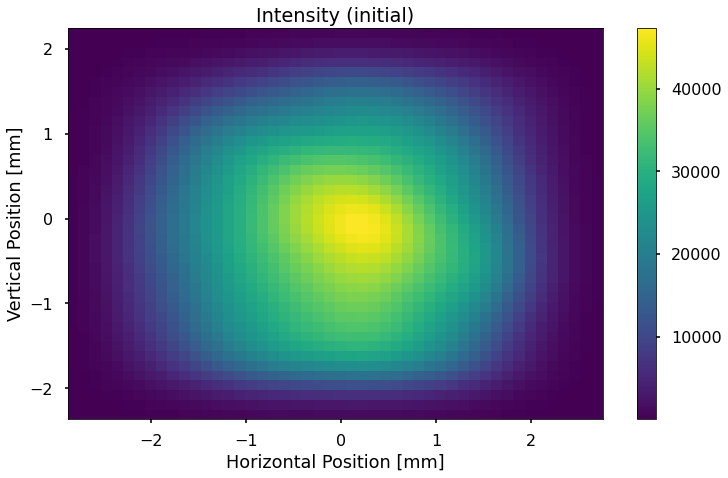

In [9]:
#Plot initial wavefront
##Initial wfr calculation
arIinit = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

print('Size of initial wavefront data array (coordinate):',np.shape(arIinit2D))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x, y, arIinit2D, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_title('Intensity (initial)')

In [10]:
# initial phase
phase0 = srwlib.array('d', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase0, wfr0, 0, 4, 3, wfr0.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_0 = np.array(phase0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsize=np.size(phase0)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_0))
x0=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
y0=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

Size of initial wavefront data array (coordinate): (40, 48)


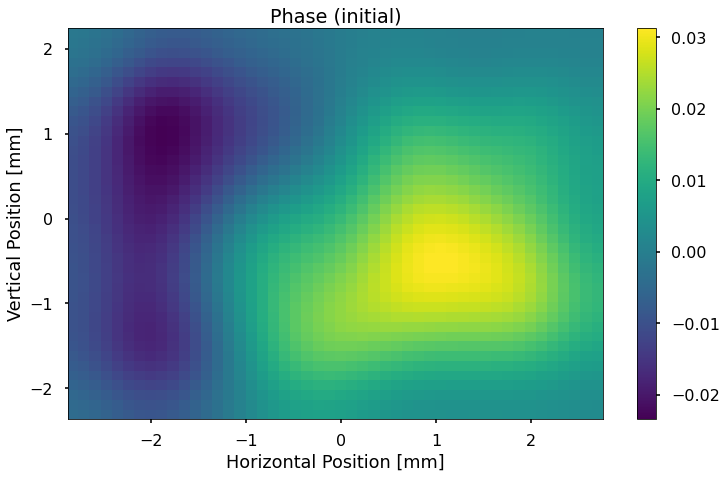

In [11]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x, y, phase_2d_0, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_title('Phase (initial)')

In [12]:
# we need to know the wavefront centroid and rms properties

def rms_calc_2d(_x, _y, f_dist):
    """
    Calculate the x and y averages and RMS of a 2d distribution f_dist(x,y)

    Args:
        _x, 2d numpy array that defines x values of the distribution
        _y, 2d numpy array that defines y values of the distribution
        f_dist, 2d numpy array that defines the x,y distribution
    
    Returns:
        x_avg, y_avg, the average values of x and y
        x_rms, y_rms, the RMS values of x and y

    Example:
        >>> xavg, yavg, xrms, yrms = rms_calc_2d(my_array)
    """
    x_f = np.multiply(_x, f_dist)
    y_f = np.multiply(_y, f_dist)
    sum_f = np.sum(f_dist)
    x_avg = np.sum(x_f) / sum_f
    y_avg = np.sum(y_f) / sum_f

    xsq_f = np.multiply(_x, x_f)
    ysq_f = np.multiply(_y, y_f)
    x_std = np.sum(xsq_f) / sum_f
    y_std = np.sum(ysq_f) / sum_f

    x_rms = math.sqrt(x_std - x_avg**2)
    y_rms = math.sqrt(y_std - y_avg**2)
    return x_avg, y_avg, x_rms, y_rms

x_avg, y_avg, x_rms, y_rms = rms_calc_2d(x, y, arIinit2D)

print(' x_avg = {0:4.2f} [mm]'.format(x_avg))
print(' y_avg = {0:4.2f} [mm]'.format(y_avg))
print(' ')
print(' x_rms = {0:4.2f} [mm]'.format(x_rms))
print(' y_rms = {0:4.2f} [mm]'.format(y_rms))

 x_avg = -0.00 [mm]
 y_avg = -0.18 [mm]
 
 x_rms = 1.04 [mm]
 y_rms = 0.95 [mm]


In [13]:
# create a laser pulse, using the wavefront created above

# photon energy corresponding to lambda = 1 micron
_LASER_PULSE_SLICE = PKDict(
    sigrW=0.000186,
    propLen=15,
    pulseE=0.001,
    poltype=1,
    sampFact=1,
    mx=0,
    my=0
)
_LASER_PULSE = PKDict(
        phE = wfr0.mesh.eStart,
        nslice = 1,
        chirp = 0,
        w0 = 2.*math.sqrt(x_rms*y_rms)*1.e-3,
        a0 = .01,
        dw0x = 0.0,
        dw0y = 0.0,
        z_waist = 0.,
        dzwx = 0.0,
        dzwy = 0.0,
        tau_fwhm = 0.1 / constants.c / math.sqrt(2.),
        z_center = 0.,
        x_shift = x_avg,
        y_shift = y_avg,
        d_to_w = 0.002,
        slice_params=_LASER_PULSE_SLICE,
)

In [14]:
# instantiate the laser pulse (this can take a few seconds)
in_pulse = PKDict(
    **_LASER_PULSE
    )
LP = pulse.LaserPulse(in_pulse)

slice=LP.slice
slice[0].wfr = wfr0

<div class="alert alert-block alert-info">
<p style="font-size:18px;">Create a negative drift and propagate the laser pulse.</p>
</div>

In [15]:
# define a simple lattice (negative drift)
length = 0.5  # [m]
lattice_neg = [(element.Drift(-length),'default')]

# propagate the pulse backwards
for iterator in lattice_neg:
    current_elem, prop_type = iterator
    LP = current_elem.propagate(LP, prop_type)

In [16]:
# transmitted pulse - intensity
wfr2=LP.slice[0].wfr

intensity2 = srwlib.array('f', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity2, wfr2, 0, 0, 3, wfr2.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intens_2d_2 = np.array(intensity2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsizei=np.size(intensity2)

print('Size of initial wavefront data array (coordinate):',np.shape(intens_2d_2))
x2=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
y2=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

Size of initial wavefront data array (coordinate): (40, 48)


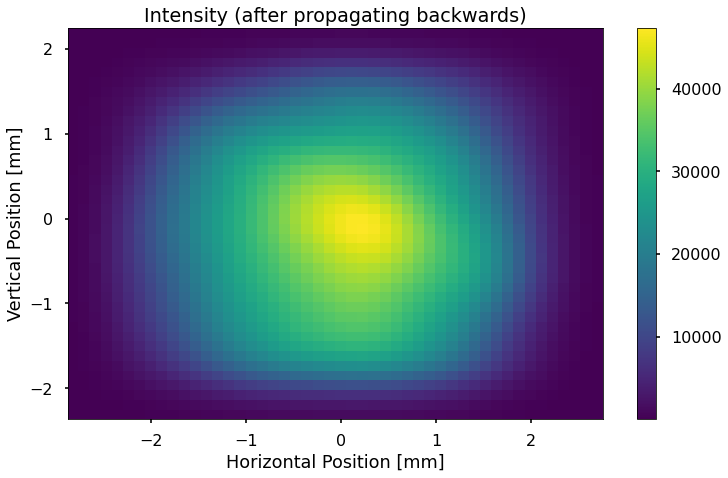

In [17]:
# plot the computed intensity
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x, y, intens_2d_2, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_title('Intensity (after propagating backwards)')

In [18]:
# transmitted pulse - phase
phase2 = srwlib.array('d', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase2, wfr2, 0, 4, 3, wfr2.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_2 = np.array(phase2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsize=np.size(phase2)

################
# this is a hack to fix odd phase values...
################
max_phase_allowed = 1.e4
if np.max(phase_2d_2) >= max_phase_allowed:
    indices = (np.where(phase_2d_2 >= max_phase_allowed))
    phase_2d_2 = array_cleaner(phase_2d_2, indices)

min_phase_allowed = -0.3e4
if np.min(phase_2d_2) <= min_phase_allowed:
    indices = (np.where(phase_2d_2 <= min_phase_allowed))
    phase_2d_2 = array_cleaner(phase_2d_2, indices)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_2))
x2=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
y2=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

# print(' ')
# print(' phase_2d_2 = ', phase_2d_2)

Size of initial wavefront data array (coordinate): (40, 48)


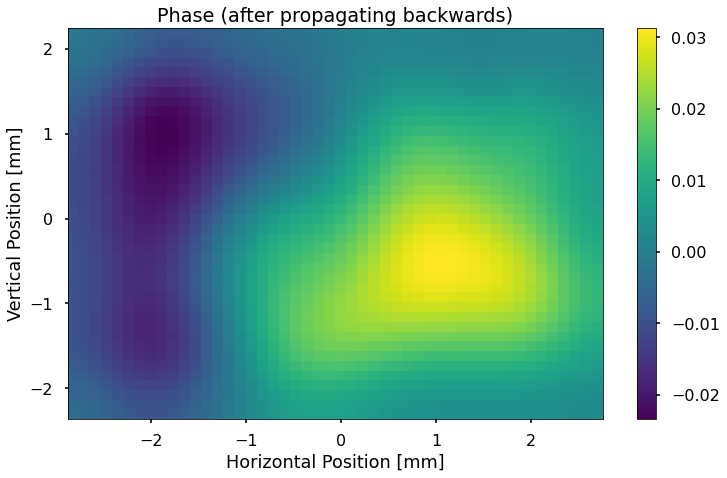

In [19]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x, y, phase_2d_2, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_title('Phase (after propagating backwards)')